<a href="https://colab.research.google.com/github/meisamgh/Machine_Learning_Trading/blob/main/Clustering_candle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install mplfinance 
import yfinance as yf

In [ ]:
# ohlc_clustering.py

import copy
import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates
from matplotlib.dates import (DateFormatter, WeekdayLocator, DayLocator, MONDAY)

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.cluster import KMeans
from mplfinance.original_flavor import candlestick_ohlc



In [ ]:
def get_open_normalised_prices(symbol, start, end):
    """
    Obtains a pandas DataFrame containing open normalised prices
    for high, low and close for a particular equities symbol
    from Yahoo Finance. That is, it creates High/Open, Low/Open 
    and Close/Open columns.
    """
    df = yf.download(symbol,  start, end)
    df["H/O"] = df["High"]/df["Open"]
    df["L/O"] = df["Low"]/df["Open"]
    df["C/O"] = df["Close"]/df["Open"]
    df.drop(
        [
            "Open", "High", "Low", 
            "Close", "Volume", "Adj Close"
        ], 
        axis=1, inplace=True
    )
    return df

In [ ]:
def plot_candlesticks(data, since):
    df = copy.deepcopy(data)
    df = df[df.index >= since]
    df.reset_index(inplace=True)
    df['date_fmt'] = df['Date'].apply(
        lambda date: mdates.date2num(date.to_pydatetime()))


    mondays = WeekdayLocator(MONDAY)
    alldays = DayLocator()
    weekFormatter = DateFormatter('%b %d')
    fig, ax = plt.subplots(figsize=(16,4))
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)


    csticks = candlestick_ohlc(
        ax, df[
            ['date_fmt', 'Open', 'High', 'Low', 'Close']
        ].values, width=0.6, 
        colorup='#000000', colordown='#ff0000'
    )
    ax.set_prop_cycle(color=['red', 'green', 'blue'])
    ax.xaxis_date()
    plt.setp(
        plt.gca().get_xticklabels(), 
        rotation=45, horizontalalignment='right'
    )
    plt.show()

def plot_3d_normalised_candles(data):
    """
    Plot a 3D scatterchart of the open-normalised bars
    highlighting the separate clusters by colour
    """
    fig = plt.figure(figsize=(12, 9))
    ax = Axes3D(fig, elev=21, azim=-136)
    ax.scatter(
        data["H/O"], data["L/O"], data["C/O"], 
        c=labels.astype(np.float)
    )
    ax.set_xlabel('High/Open')
    ax.set_ylabel('Low/Open')
    ax.set_zlabel('Close/Open')
    plt.show()
    

In [ ]:
def plot_cluster_ordered_candles(data):

    mondays = WeekdayLocator(MONDAY)
    alldays = DayLocator()
    weekFormatter = DateFormatter("")
    fig, ax = plt.subplots(figsize=(18,10))
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)


    df = copy.deepcopy(data)
    df.sort_values(by="Cluster", inplace=True)
    df.reset_index(inplace=True)
    df["clust_index"] = df.index
    df["clust_change"] = df["Cluster"].diff()
    change_indices = df[df["clust_change"] != 0]

    csticks = candlestick_ohlc(
        ax, df[
            ["clust_index", 'Open', 'High', 'Low', 'Close']
        ].values, width=0.6, 
        colorup='#000000', colordown='#ff0000'
    )
    ax.set_prop_cycle(color=['red', 'green', 'blue'])

    for row in change_indices.iterrows():
        plt.axvline(
            row[1]["clust_index"], 
            linestyle="dashed", c="blue"
        )
    plt.xlim(0, len(df))
    plt.setp(
        plt.gca().get_xticklabels(), 
        rotation=45, horizontalalignment='right'
    )
    plt.show()

In [ ]:
def create_follow_cluster_matrix(data):

    data["ClusterTomorrow"] = data["Cluster"].shift(-1)
    data.dropna(inplace=True)
    data["ClusterTomorrow"] = data["ClusterTomorrow"].apply(int)
    sp500["ClusterMatrix"] = list(zip(data["Cluster"], data["ClusterTomorrow"]))
    cmvc = data["ClusterMatrix"].value_counts()
    clust_mat = np.zeros( (k, k) )
    for row in cmvc.iteritems():
        clust_mat[row[0]] = row[1]*100.0/len(data)
    print("Cluster Follow-on Matrix:")
    print(clust_mat)

In [ ]:

start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2021, 1, 31)
sp500 = yf.download("BTC-USD", start, end)

sp500_norm = get_open_normalised_prices("BTC-USD", start, end)
k = 3
km = KMeans(n_clusters=k, random_state=42)
km.fit(sp500_norm)
labels = km.labels_
sp500["Cluster"] = labels
sp500.sort_values('Cluster' ,inplace = True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


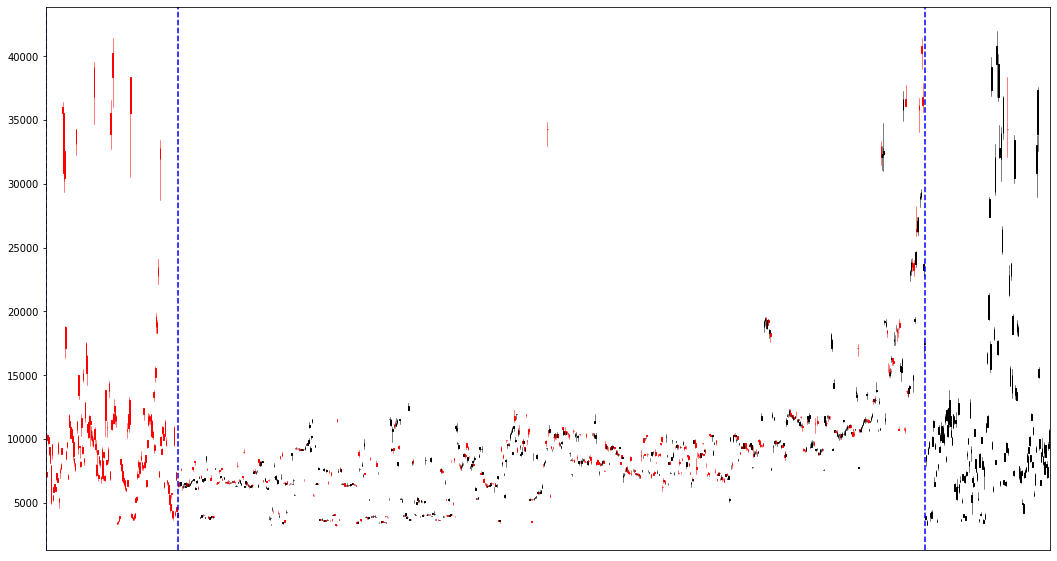

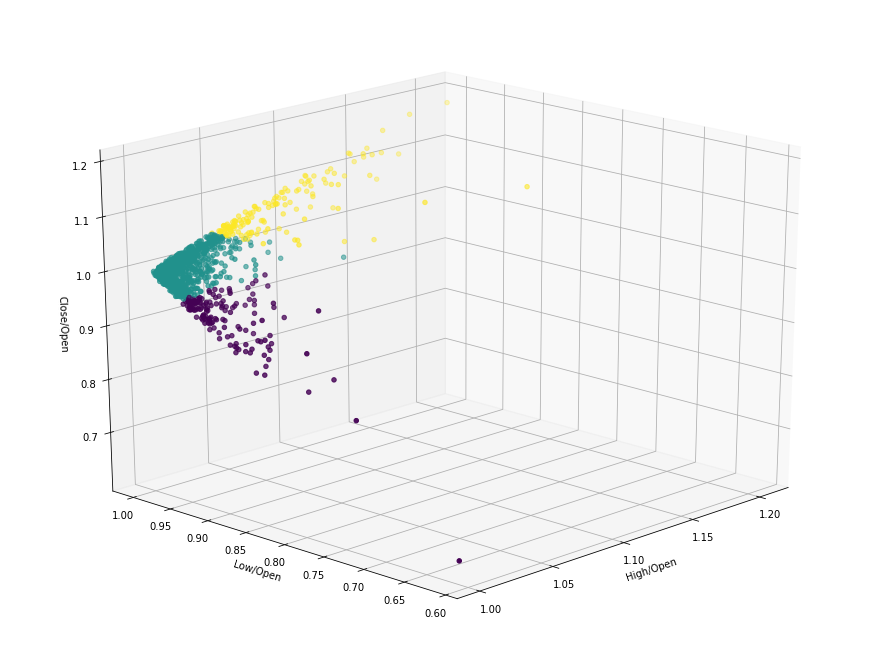

In [ ]:
plot_cluster_ordered_candles(sp500)
plot_3d_normalised_candles(sp500_norm)

In [ ]:
sp500.Cluster.value_counts()

1    838
0    149
2    140
Name: Cluster, dtype: int64

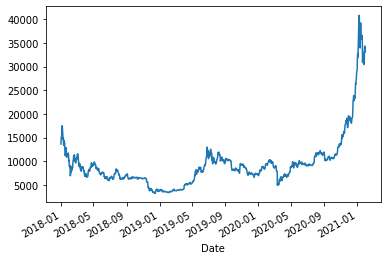

In [ ]:
sp500.Close.plot()

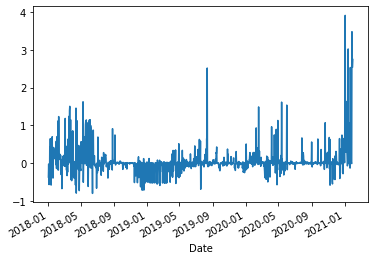

In [ ]:
sp500.Close.pct_change().plot()